## Load and plot DR/Templeton ephys data

In [23]:
#Import packages
import pandas as pd
import h5py
import numpy as np
import scipy as sp
import scipy.signal as sg
import xarray as xr
import os
import matplotlib.pyplot as plt
from matplotlib import patches
import ast
import glob

from DR_analysis_utils import Session, makePSTH, make_neuron_time_trials_tensor

%matplotlib notebook

In [24]:
#Set paths to experiment folders
main_path = [
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-07-26_14-09-36_620263\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-07-27_13-57-17_620263\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-08-02_15-40-19_620264\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-19_13-48-26_628801\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-26_12-48-09_636397\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-27_11-37-08_636397\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-12-05_13-08-02_644547\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-12-06_12-35-35_644547\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2023-01-17_11-39-17_646318\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2023-01-18_10-44-55_646318\processed",
    r"Y:\2023-02-27_08-14-30_649944\processed",
    r"Y:\2023-02-28_09-33-43_649944\processed",
    # DR mice
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220815\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220816\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\DRpilot_626791_20220817\processed",
#     r"Y:\DRpilot_644867_20230220\processed",
#     r"Y:\DRpilot_644867_20230221\processed",
#     r"Y:\DRpilot_644867_20230222\processed",
#     r"Y:\DRpilot_644867_20230223\processed",   
]

mouseIDs = ['620263','620263','620264','628801','636397','636397','644547','644547',
            '646318','646318','649944','649944',
           #DR mice
           '626791','626791','626791',
           '644867','644867','644867','644867',]
exp_nums = [1,2, 1, 1, 1,2, 1,2, 
            1,2, 1,2, 
           #DR mice
           1,2,3,
           1,2,3,4]

### Load/initialize data from one session

In [110]:
sel_session=13
session=Session(path=main_path[sel_session]) 
session.assign_unit_areas()

probeA areas found
probeB areas found
probeC areas found
probeF areas found


In [130]:
session.assign_unit_areas()

tissuecyte folder not found
found and loaded manual area assignments


In [ ]:
print(session.metadata['mouseID']+' session ',session.metadata['ephys_session_num'])

In [ ]:
# trials table
session.trials

In [ ]:
# units table
session.units

In [ ]:
# spike times from one unit
session.spike_times[session.units.index[0]]

In [ ]:
# information about each frame
session.frames

In [ ]:
session.rf_trials

### Create a convenient data array using "xarray"

In [111]:
# loop through sessions and make unit xarrays
time_before_flash = 0.5
trial_duration = 2
bin_size = 0.001


# Make tensor (3-D matrix [units,time,trials])
trial_tensor = make_neuron_time_trials_tensor(session.good_units, session.spike_times, 
                                              session.trials,time_before_flash, trial_duration, 
                                              bin_size)

# make xarray
session.trial_da = xr.DataArray(trial_tensor, dims=("unit_id", "time", "trials"), 
                           coords={
                               "unit_id": session.good_units.index.values,
                               "time": np.arange(0, trial_duration, bin_size)-time_before_flash,
                               "trials": session.trials.index.values
                               })

### Plot unit density across probes

<IPython.core.display.Javascript object>


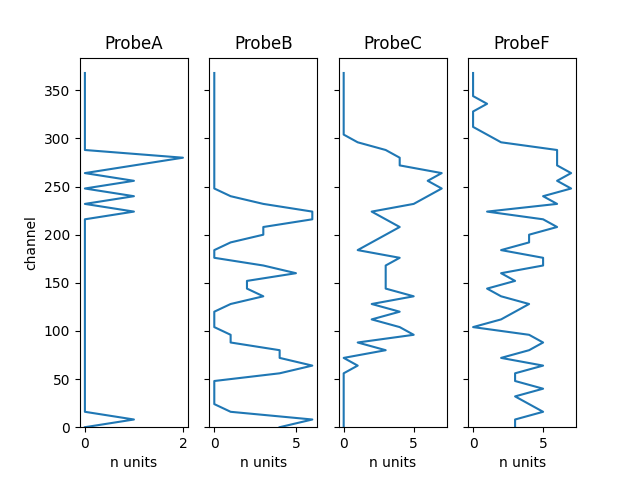

In [65]:
probes = session.good_units['probe'].unique()
ch_bins=np.arange(0,384,8)

units_by_channel = session.good_units[['probe','peak_channel']].value_counts()

fig,ax=plt.subplots(1,len(probes))

for ip,pr in enumerate(probes):
    unit_hist,edges=np.histogram(units_by_channel[pr].sort_index().index,bins=ch_bins)
    ax[ip].plot(unit_hist,ch_bins[:-1])
    ax[ip].set_ylim([0,384])
    ax[ip].set_xlabel('n units')
    ax[ip].set_title('Probe'+pr)
    if ip>0:
        ax[ip].set_yticklabels([])
    else:
        ax[ip].set_ylabel('channel')
        

In [52]:
#estimate fraction of units in cortex


#input channel rage and probe, caculate the fraction of units contained there
sel_probe='F'
channel_range=[150,350]

units_in_range=len(session.good_units.query('probe == @sel_probe and \
                                           peak_channel >= @channel_range[0] and \
                                           peak_channel < @channel_range[1]'))

probe_units=len(session.good_units.query('probe == @sel_probe'))

print('Probe'+sel_probe+' fraction units in channel range:')
print(units_in_range/probe_units)



ProbeF fraction units in channel range:
0.5754716981132075


### Plot rasters -- sorted by stimulus duration

In [ ]:
#Plot rasters: sort by stimulus duration

#select unit either by its location in the unit table or its ID    
unit_id=session.good_units.index[145]
# unit_id=10121

fig,ax=plt.subplots(2,2,figsize=(8,7))
ax=ax.flatten()
stim_types=['vis1','vis2','sound1','sound2']

color_options = ['green','blue','red','orange']

trial_color_map = {}
for ii,ss in enumerate(stim_types):
    trial_color_map[ss]=color_options[ii]


for si,ss in enumerate(stim_types):
    stim_trials = session.trials[session.trials['trialStimID']==ss]
    stim_trials_sorted = stim_trials.sort_values(by='trial_stim_dur',axis=0,ascending=True)
    
    sel_trials = session.trial_da.sel(trials=stim_trials_sorted.index.values)
    
    #find the ilocs of block transitions
    sel_trials_table = session.trials.loc[stim_trials.index.values]
    column_changes = sel_trials_table['trialstimRewarded'].shift() != sel_trials_table['trialstimRewarded']
    block_changes = sel_trials_table[column_changes]
    
    for it,tt in enumerate(sel_trials.trials.values):
        trial_spikes = sel_trials.sel(unit_id=unit_id,trials=tt)
        trial_color=[]

        trial_color = trial_color_map[session.trials['trialStimID'][tt]]

        trial_spike_times = trial_spikes.time[trial_spikes.values.astype('bool')]
        ax[si].vlines(trial_spike_times,ymin=it,ymax=it+1,linewidth=0.75,color='k')
        
        ax[si].vlines(stim_trials_sorted['trial_stim_dur'].loc[tt],ymin=it-.01,ymax=it+1.01,linewidth=1,color='k')

    if len(block_changes)>1:
        if block_changes.iloc[0]['trialstimRewarded']=='vis1':
            start_block=1
        elif block_changes.iloc[0]['trialstimRewarded']=='sound1':
            start_block=0

        for xx in np.asarray([0,2,4])+start_block:
            start_iloc=sel_trials_table.index.get_loc(block_changes.index[xx])
            if (xx+1)>(len(block_changes)-1):
                end_iloc=len(sel_trials_table)
            else:
                end_iloc=sel_trials_table.index.get_loc(block_changes.index[xx+1])
            temp_patch=patches.Rectangle([-0.5,start_iloc],1.5,end_iloc-start_iloc,
                                        color=[0.5,0.5,0.5],alpha=0.15)
            ax[si].add_patch(temp_patch)
        
    ax[si].set_xlim([-0.5,1.5])

    ax[si].axvline(0,color='k',linewidth=1)

    ax[si].set_title(ss)

fig.suptitle('unit:'+str(unit_id)+' Probe'+session.good_units['probe'].loc[unit_id]+
             ' ch:'+str(session.good_units['peak_channel'].loc[unit_id]))

fig.tight_layout()



### Plot heatmaps

In [94]:
#Average & normalize responses of each unit to each stimulus
gwindow = sg.gaussian(15, std=5)

#find baseline mean and std per unit
baseline_mean_per_trial=session.trial_da.sel(time=slice(-0.5,-0.4)).mean(dim=["time"])
baseline_mean=baseline_mean_per_trial.mean(dim="trials").values
baseline_std=baseline_mean_per_trial.std(dim="trials").values

#find unique stimuli
stimuli = np.unique(session.trials['trialStimID'])

#remove catch trials for this plot
stimuli = stimuli[stimuli!='catch']

#pre-allocate array for average
unit_frs_by_stim = np.zeros((len(session.trial_da.unit_id),len(session.trial_da.time),len(stimuli)))

#normalize each unit's avg FRs to its baseline  FR
for ss,stim in enumerate(stimuli):
    stim_trials = (session.trials.query('trialStimID==@stim')).index.values
    unit_frs_by_stim[:,:,ss] = session.trial_da.sel(trials=stim_trials).mean(dim="trials").values
    
    # z-score each unit rel to its baseline
    unit_frs_by_stim[:,:,ss] = ((unit_frs_by_stim[:,:,ss].T- baseline_mean.T)/baseline_std.T).T
    
    for iu in range(0,len(session.trial_da.unit_id)):
        unit_frs_by_stim[iu,:,ss]=sg.convolve(unit_frs_by_stim[iu,:,ss],
                                                gwindow,mode='same')/np.sum(gwindow)

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_41956\3886192632.py:24: RuntimeWarning: divide by zero encountered in true_divide
  unit_frs_by_stim[:,:,ss] = ((unit_frs_by_stim[:,:,ss].T- baseline_mean.T)/baseline_std.T).T
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_41956\3886192632.py:24: RuntimeWarning: invalid value encountered in true_divide
  unit_frs_by_stim[:,:,ss] = ((unit_frs_by_stim[:,:,ss].T- baseline_mean.T)/baseline_std.T).T
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_41956\3886192632.py:24: RuntimeWarning: divide by zero encountered in true_divide
  unit_frs_by_stim[:,:,ss] = ((unit_frs_by_stim[:,:,ss].T- baseline_mean.T)/baseline_std.T).T
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_41956\3886192632.py:24: RuntimeWarning: invalid value encountered in true_divide
  unit_frs_by_stim[:,:,ss] = ((unit_frs_by_stim[:,:,ss].T- baseline_mean.T)/baseline_std.T).T
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_41956\3886192632.py:24: RuntimeWarning

In [95]:
#Find/define probe borders for plotting

probe_borders=np.where(session.good_units['probe'].iloc[:-1].values!=session.good_units['probe'].iloc[1:].values)[0]
all_edges=np.hstack([0,probe_borders,len(session.good_units)])
midpoints=all_edges[:-1]+(all_edges[1:]-all_edges[:-1])/2
probe_labels=session.good_units['probe'].iloc[midpoints.astype('int')].values

<IPython.core.display.Javascript object>


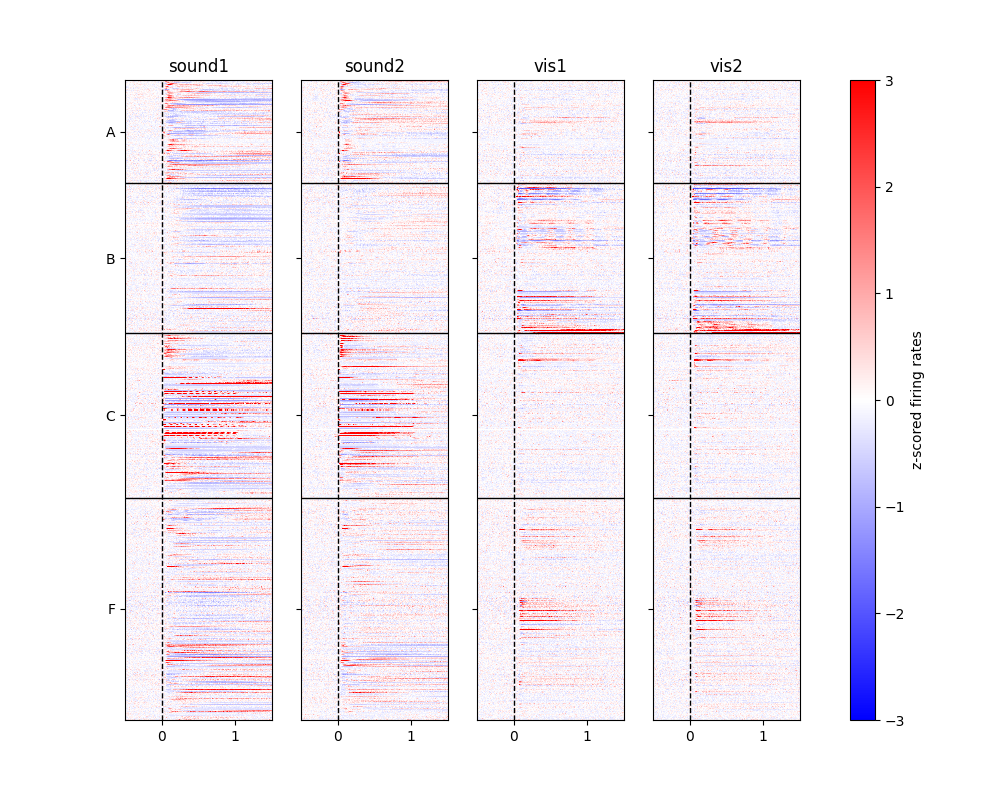

Text(0, 0.5, 'z-scored firing rates')

In [97]:
# plot heatmaps
# ordered by ascending channel number - top is tip of probe

fig,ax=plt.subplots(1,4,figsize=(10,8))
for xx in range(0,len(stimuli)): 
    im = ax[xx].imshow(unit_frs_by_stim[:,:,xx],aspect='auto',vmin=-3,vmax=3,
                   cmap=plt.get_cmap('bwr'),interpolation='none',
                   extent=(-time_before_flash,trial_duration-time_before_flash,
                           0,unit_frs_by_stim.shape[0]))
    
    ax[xx].axvline(0,color='k',linestyle='--',linewidth=1)
    ax[xx].set_title(stimuli[xx])
    ax[xx].set_xlim(-0.5,1.5)
    ax[xx].hlines(unit_frs_by_stim.shape[0]-probe_borders,xmin=-0.5,xmax=1.5,
                   color='k',linewidth=1)
    ax[xx].set_yticks(unit_frs_by_stim.shape[0]-midpoints)
    ax[xx].set_yticklabels(probe_labels)
    if xx>0:
        ax[xx].set_yticklabels([])

# this adjusts the other plots to make space for the colorbar
fig.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.3) 
cax = plt.axes([0.85, 0.1, 0.025, 0.8])
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_ylabel('z-scored firing rates')


### Plot heatmaps by stimulus duration

In [ ]:
#Find/define probe borders for plotting

probe_borders=np.where(session.good_units['probe'].iloc[:-1].values!=session.good_units['probe'].iloc[1:].values)[0]
all_edges=np.hstack([0,probe_borders,len(session.good_units)])
midpoints=all_edges[:-1]+(all_edges[1:]-all_edges[:-1])/2
probe_labels=session.good_units['probe'].iloc[midpoints.astype('int')].values

In [ ]:
#Average & normalize responses of each unit to each stimulus

gwindow = sg.gaussian(15, std=5)

#find baseline mean and std per unit
baseline_mean_per_trial=session.trial_da.sel(time=slice(-0.5,-0.4)).mean(dim=["time"])
baseline_mean=baseline_mean_per_trial.mean(dim="trials").values
baseline_std=baseline_mean_per_trial.std(dim="trials").values

#find unique stimuli
stimuli = np.unique(session.trials['trialStimID'])

#remove catch trials for this plot
stimuli = stimuli[stimuli!='catch']

#find stimulus durations
stim_dur = session.trials['trial_stim_dur'].unique()
#remove duration = 0 for this plot
stim_dur = stim_dur[stim_dur!=0]

#pre-allocate array for average
unit_frs_by_stim = np.zeros((len(session.trial_da.unit_id),len(session.trial_da.time),len(stimuli),len(stim_dur)))

#loop through stimulus durations
for dd,dur in enumerate(stim_dur):
    #normalize each unit's avg FRs to its baseline  FR
    for ss,stim in enumerate(stimuli):
        
        stim_trials = (session.trials.query('trialStimID==@stim and trial_stim_dur==@dur')).index.values
        
#         baseline_mean_per_trial=session.trial_da.sel(time=slice(-0.5,-0.1),trials=stim_trials).mean(dim=["time"])
#         baseline_mean=baseline_mean_per_trial.mean(dim="trials").values
#         baseline_std=baseline_mean_per_trial.std(dim="trials").values
        
        unit_frs_by_stim[:,:,ss,dd] = session.trial_da.sel(trials=stim_trials).mean(dim="trials").values

        # z-score each unit rel to its baseline
        unit_frs_by_stim[:,:,ss,dd] = ((unit_frs_by_stim[:,:,ss,dd].T- baseline_mean.T)/baseline_std.T).T
        
        for iu in range(0,len(session.trial_da.unit_id)):
            unit_frs_by_stim[iu,:,ss,dd]=sg.convolve(unit_frs_by_stim[iu,:,ss,dd],
                                                     gwindow,mode='same')/np.sum(gwindow)
        

In [ ]:
# plot heatmaps
# ordered by ascending channel number - top is tip of probe

for dd,dur in enumerate(stim_dur):
    fig,ax=plt.subplots(1,4,figsize=(10,8))
    for xx in range(0,len(stimuli)): 
        im = ax[xx].imshow(unit_frs_by_stim[:,:,xx,dd],aspect='auto',vmin=-3,vmax=3,
                       cmap=plt.get_cmap('bwr'),interpolation='none',
                       extent=(-time_before_flash,trial_duration-time_before_flash,
                               0,unit_frs_by_stim.shape[0]))

        ax[xx].axvline(0,color='k',linestyle='--',linewidth=1)
        ax[xx].axvline(dur,color='k',linestyle='--',linewidth=1)
        ax[xx].set_title(stimuli[xx])
        ax[xx].set_xlim(-0.5,1.5)
        ax[xx].hlines(unit_frs_by_stim.shape[0]-probe_borders,xmin=-0.5,xmax=1.5,
                       color='k',linewidth=1)
        ax[xx].set_yticks(unit_frs_by_stim.shape[0]-midpoints)
        ax[xx].set_yticklabels(probe_labels)
        if xx>0:
            ax[xx].set_yticklabels([])
    
    fig.suptitle(str(dur)+' sec stimuli')
    # this adjusts the other plots to make space for the colorbar
    fig.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.3) 
    cax = plt.axes([0.85, 0.1, 0.025, 0.8])
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.set_ylabel('z-scored firing rates')


In [ ]:
# session.trial_da.sel(trials=stim_trials).mean(dim="trials").values.shape

### Plot PSTH according to probe and channel range

In [122]:
# choose channel range and probe

channel_range=[0,50]
sel_probe='B'

stimuli = np.unique(session.trials['trialStimID'])

stim_PSTHs = {}

sel_units = session.good_units.query('probe == @sel_probe and \
                                           peak_channel >= @channel_range[0] and \
                                           peak_channel < @channel_range[1]')
for stim in stimuli:

    stim_trials = session.trials.query('trialStimID == @stim').index

    stim_PSTHs[stim]=[]
    stim_PSTHs[stim].append(session.trial_da.sel(
                            unit_id=sel_units.index,
                            trials=stim_trials).mean(dim=['trials']))


In [123]:
# smooth each unit's PSTH
gwindow = sg.gaussian(50, std=25)
stim_PSTH_smooth={}
for stim in stimuli:
    stim_PSTH_smooth[stim]=np.zeros(stim_PSTHs[stim][0].shape)

    for iu,uu in enumerate(stim_PSTHs[stim][0].unit_id.values):
        stim_PSTH_smooth[stim][iu,:]=sg.convolve(stim_PSTHs[stim][0].sel(unit_id=uu),
                                                 gwindow,mode='same')/np.sum(gwindow)


<IPython.core.display.Javascript object>


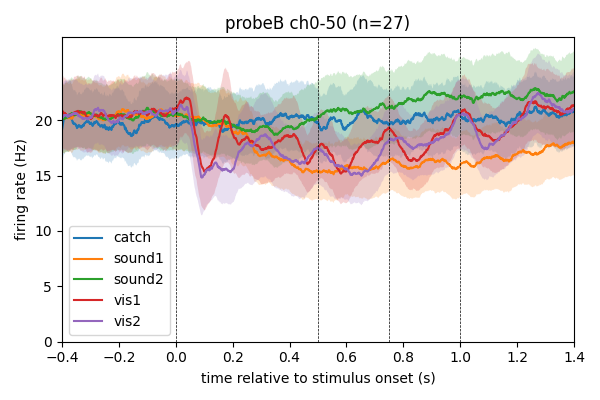

In [124]:
fig,ax=plt.subplots(1,1,figsize=(6,4))

for stim in stimuli:

    y=np.nanmean(stim_PSTH_smooth[stim],0)
    err=np.nanstd(stim_PSTH_smooth[stim],0)/np.sqrt(stim_PSTH_smooth[stim].shape[0])
    linex=ax.plot(stim_PSTHs[stim][0].time, y)
    plt.fill_between(stim_PSTHs[stim][0].time, y-err, y+err,
        alpha=0.2, edgecolor=None, facecolor=linex[0].get_color())


ax.set_title('probe'+sel_probe+' ch'+str(channel_range[0])+'-'+
             str(channel_range[1])+' (n='+str(len(stim_PSTHs[stim][0].unit_id))+')')
ax.set_xlabel('time relative to stimulus onset (s)')
ax.set_ylabel('firing rate (Hz)')
ax.set_xlim([-0.4,1.4])

ax.set_yticks([0,5,10,15,20])
ax.legend(stimuli)

stim_lines=[0,0.5,0.75,1]
for sl in stim_lines:
    ax.axvline(sl,color='k',linestyle='--',linewidth=0.5)

fig.tight_layout()

### Bin by trials - do responses change over the course of the session?

In [ ]:
# choose channel range and probe

trial_bin_size = 40


channel_range=[0,100]
sel_probe='F'

stim = 'sound2'

stim_PSTHs = {}

sel_units = session.good_units.query('probe == @sel_probe and \
                                           peak_channel >= @channel_range[0] and \
                                           peak_channel < @channel_range[1]')

stim_trials = session.trials.query('trialStimID == @stim').index

trial_bins = np.arange(0,len(stim_trials),trial_bin_size)

mean_stim_PSTH = session.trial_da.sel(unit_id=sel_units.index,
                                      trials=stim_trials).mean(dim=['trials'])

trial_bin_PSTH = np.zeros((mean_stim_PSTH.shape[0],
                           mean_stim_PSTH.shape[1],
                           np.ceil(len(stim_trials)/trial_bin_size).astype(int)))

for it,tt in enumerate(trial_bins):

    trial_bin_PSTH[:,:,it]=session.trial_da.sel(unit_id=sel_units.index,
                                                trials=stim_trials[tt:tt+trial_bin_size]).mean(dim=['trials'])

# smooth each unit's PSTH
gwindow = sg.gaussian(50, std=25)
trial_bin_PSTH_smooth=np.zeros((trial_bin_PSTH.shape))

for it in range(0,trial_bin_PSTH.shape[2]):
    for iu in range(0,trial_bin_PSTH.shape[0]):
        trial_bin_PSTH_smooth[iu,:,it]=sg.convolve(trial_bin_PSTH[iu,:,it],gwindow,mode='same')/np.sum(gwindow)


<IPython.core.display.Javascript object>


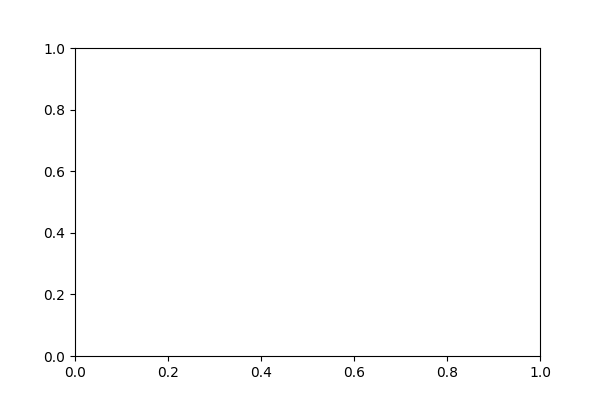

NameError: name 'trial_bin_PSTH' is not defined

In [131]:
fig,ax=plt.subplots(1,1,figsize=(6,4))

for it in range(0,trial_bin_PSTH.shape[2]):
    
    y=np.nanmean(trial_bin_PSTH_smooth[:,:,it],0)
    err=np.nanstd(trial_bin_PSTH_smooth[:,:,it],0)/np.sqrt(trial_bin_PSTH_smooth[:,:,it].shape[0])
    linex=ax.plot(mean_stim_PSTH[0].time, y)
    plt.fill_between(mean_stim_PSTH[0].time, y-err, y+err,
        alpha=0.2, edgecolor=None, facecolor=linex[0].get_color())


ax.set_title('probe'+sel_probe+' ch'+str(channel_range[0])+'-'+
             str(channel_range[1]))
ax.set_xlabel('time relative to stimulus onset (s)')
ax.set_ylabel('firing rate (Hz)')
ax.set_xlim([-0.4,1.4])

ax.set_yticks([0,5,10,15,20])
ax.legend(trial_bins)

stim_lines=[0,0.5,0.75,1]
for sl in stim_lines:
    ax.axvline(sl,color='k',linestyle='--',linewidth=0.5)

fig.tight_layout()

### area-specific plots

In [112]:
# heatmaps

#Average & normalize responses of each unit to each stimulus
gwindow = sg.gaussian(15, std=5)

#find baseline mean and std per unit
baseline_mean_per_trial=session.trial_da.sel(time=slice(-0.5,-0.4)).mean(dim=["time"])
baseline_mean=baseline_mean_per_trial.mean(dim="trials").values
baseline_std=baseline_mean_per_trial.std(dim="trials").values

#find unique stimuli
stimuli = np.unique(session.trials['trialStimID'])

#remove catch trials for this plot
stimuli = stimuli[stimuli!='catch']

#pre-allocate array for average
unit_frs_by_stim = np.zeros((len(session.trial_da.unit_id),len(session.trial_da.time),len(stimuli)))

#normalize each unit's avg FRs to its baseline  FR
for ss,stim in enumerate(stimuli):
    stim_trials = (session.trials.query('trialStimID==@stim')).index.values
    unit_frs_by_stim[:,:,ss] = session.trial_da.sel(trials=stim_trials).mean(dim="trials").values
    
    # z-score each unit rel to its baseline
    unit_frs_by_stim[:,:,ss] = ((unit_frs_by_stim[:,:,ss].T- baseline_mean.T)/baseline_std.T).T
    
    for iu in range(0,len(session.trial_da.unit_id)):
        unit_frs_by_stim[iu,:,ss]=sg.convolve(unit_frs_by_stim[iu,:,ss],
                                                gwindow,mode='same')/np.sum(gwindow)

In [113]:
#Find/define probe borders for plotting

probe_borders=np.where(session.good_units['area'].iloc[:-1].values!=session.good_units['area'].iloc[1:].values)[0]
all_edges=np.hstack([0,probe_borders,len(session.good_units)])
midpoints=all_edges[:-1]+(all_edges[1:]-all_edges[:-1])/2
probe_labels=session.good_units['area'].iloc[midpoints.astype('int')].values

In [128]:
session.good_units['area'].unique()

array(['', 'VIS', 'AUD'], dtype=object)

<IPython.core.display.Javascript object>


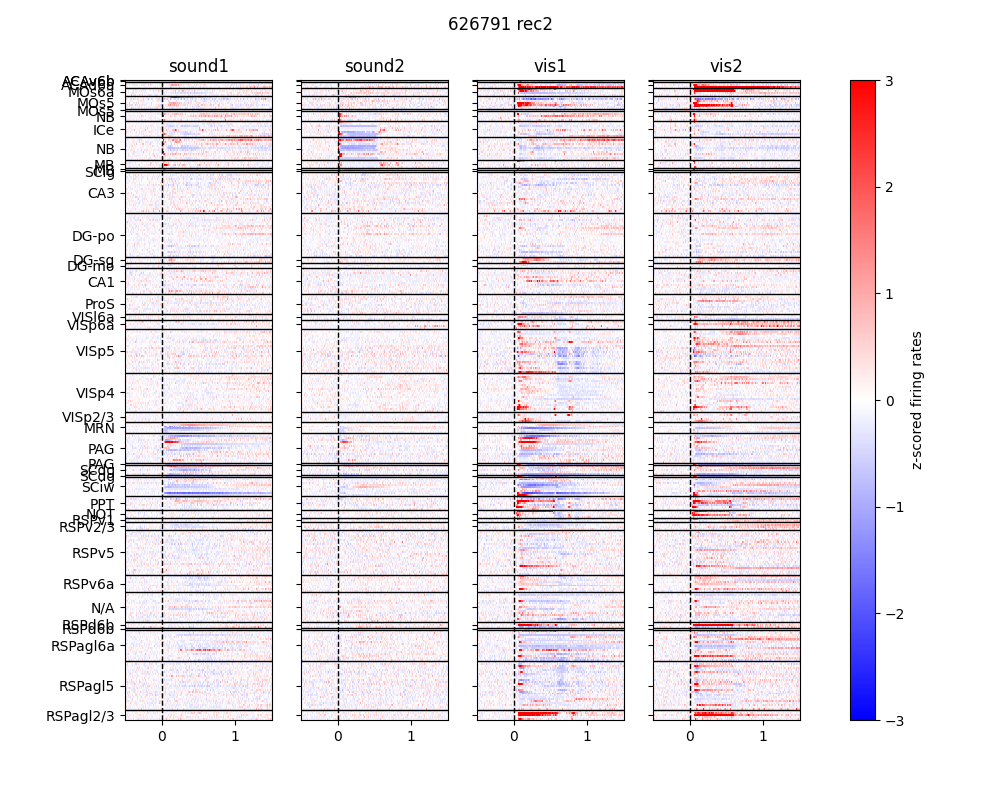

Text(0, 0.5, 'z-scored firing rates')

In [114]:
# plot heatmaps
# ordered by ascending channel number - top is tip of probe

fig,ax=plt.subplots(1,4,figsize=(10,8))

for xx in range(0,len(stimuli)): 
    im = ax[xx].imshow(unit_frs_by_stim[:,:,xx],aspect='auto',vmin=-3,vmax=3,
                   cmap=plt.get_cmap('bwr'),interpolation='none',
                   extent=(-time_before_flash,trial_duration-time_before_flash,
                           0,unit_frs_by_stim.shape[0]))
    
    ax[xx].axvline(0,color='k',linestyle='--',linewidth=1)
    ax[xx].set_title(stimuli[xx])
    ax[xx].set_xlim(-0.5,1.5)
    ax[xx].hlines(unit_frs_by_stim.shape[0]-probe_borders,xmin=-0.5,xmax=1.5,
                   color='k',linewidth=1)
    ax[xx].set_yticks(unit_frs_by_stim.shape[0]-midpoints)
    ax[xx].set_yticklabels(probe_labels)
    if xx>0:
        ax[xx].set_yticklabels([])

fig.suptitle(session.metadata['mouseID']+' rec'+str(session.metadata['ephys_session_num']))
        
# this adjusts the other plots to make space for the colorbar
fig.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.3) 
cax = plt.axes([0.85, 0.1, 0.025, 0.8])
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_ylabel('z-scored firing rates')


In [ ]:
# plot vis vs. sound response rates
session.trials

In [115]:
avg_run_speed=np.zeros(len(session.trials))

for tt in range(0,len(session.trials)):
    startFrame=session.trials['trialStartFrame'].iloc[tt]
    endFrame=session.trials['trialStimStartFrame'].iloc[tt]
    avg_run_speed[tt]=np.nanmean(session.frames['runningSpeed'][startFrame:endFrame])
    
session.trials['avg_run_speed'] = avg_run_speed

In [ ]:
# session.frames

<IPython.core.display.Javascript object>


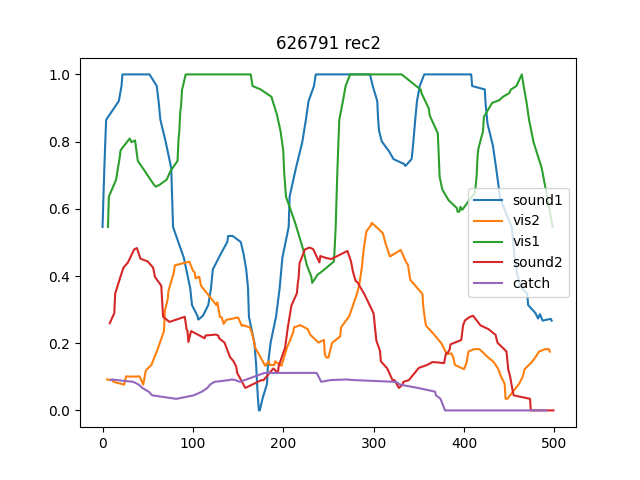

Text(0.5, 1.0, '626791 rec2')

In [116]:
# plot smoothed response rate to each stimulus
stims=session.trials['trialStimID'].unique()

trials_to_smooth=5
gwindow = sg.gaussian(trials_to_smooth*3, std=trials_to_smooth)

fig,ax=plt.subplots(1,1)
for ss in stims:
    stimTrials=session.trials.query('trialStimID == @ss')
    ax.plot(stimTrials.index,sg.convolve(stimTrials['trial_response'].values,
                                         gwindow,mode='same')
                                        /np.sum(gwindow))
    
ax.legend(stims)
ax.set_title(mouseIDs[sel_session]+' rec'+str(exp_nums[sel_session]))

<IPython.core.display.Javascript object>


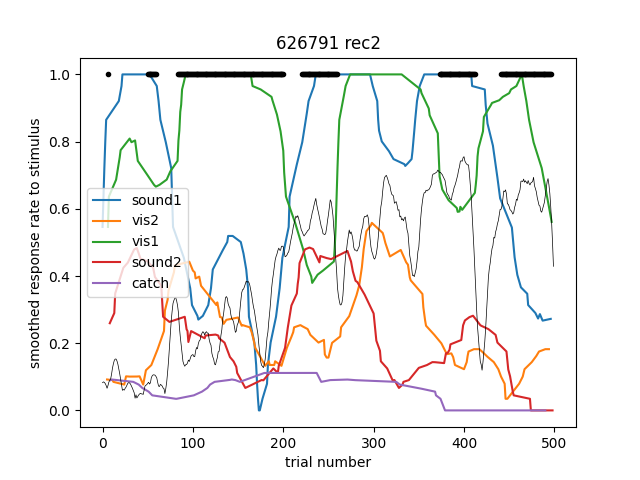

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_54180\4091891659.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimTrials[ss+'_smooth']=sg.convolve(stimTrials['trial_response'].values,gwindow,mode='same')/np.sum(gwindow)
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_54180\4091891659.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimTrials[ss+'_smooth']=sg.convolve(stimTrials['trial_response'].values,gwindow,mode='same')/np.sum(gwindow)
C:\Users\ethan.mcbride\AppData\Local\Temp\ipyker

Text(0, 0.5, 'smoothed response rate to stimulus')

In [117]:
# interpolate response rate to each stimulus across all trials

stims=session.trials['trialStimID'].unique()

trials_to_smooth=5
gwindow = sg.gaussian(trials_to_smooth*3, std=trials_to_smooth)

fig,ax=plt.subplots(1,1)

for ss in stims:
    stimTrials=session.trials.query('trialStimID == @ss')
    stimTrials[ss+'_smooth']=sg.convolve(stimTrials['trial_response'].values,gwindow,mode='same')/np.sum(gwindow)

    interp_func=sp.interpolate.interp1d(stimTrials.index,stimTrials[ss+'_smooth'])

    xnew=np.arange(np.min(stimTrials.index),np.max(stimTrials.index))
    temp_interp=interp_func(xnew)
    interp_full=np.zeros((len(session.trials)))
    interp_full[:]=np.nan
    interp_full[np.min(stimTrials.index):np.max(stimTrials.index)]=temp_interp
    
    session.trials[ss+'_interp']=interp_full
    
#     ax.plot(xnew,temp_interp)
    ax.plot(np.arange(0,len(session.trials)),interp_full)

    
high_performance_trials=session.trials.query('abs(vis1_interp - sound1_interp)>=0.3').index
ax.plot(high_performance_trials,np.ones(len(high_performance_trials)),'k.')
ax.plot(sg.convolve(session.trials['avg_run_speed']
                    /session.trials['avg_run_speed'].max(),
                    gwindow,mode='same')/np.sum(gwindow),'k',linewidth=0.5)

ax.legend(stims)
ax.set_title(mouseIDs[sel_session]+' rec'+str(exp_nums[sel_session]))
ax.set_xlabel('trial number')
ax.set_ylabel('smoothed response rate to stimulus')

In [ ]:
session.trials.query('abs(vis1_interp - sound1_interp)>=0.4').index

In [118]:
def average_across_trials(trials):
    ntrials_per_stim={}
    
    #Average & normalize responses of each unit to each stimulus
    gwindow = sg.gaussian(15, std=5)

    #find baseline mean and std per unit
    baseline_mean_per_trial=session.trial_da.sel(time=slice(-0.5,-0.4)).mean(dim=["time"])
    baseline_mean=baseline_mean_per_trial.mean(dim="trials").values
    baseline_std=baseline_mean_per_trial.std(dim="trials").values

    #find unique stimuli
    stimuli = np.unique(session.trials['trialStimID'])

    #remove catch trials for this plot
    stimuli = stimuli[stimuli!='catch']

    #pre-allocate array for average
    unit_frs_by_stim = np.zeros((len(session.trial_da.unit_id),len(session.trial_da.time),len(stimuli)))
    
    #normalize each unit's avg FRs to its baseline  FR
    for ss,stim in enumerate(stimuli):
        stim_trials = trials.query('trialStimID == @stim').index.values
        ntrials_per_stim[stim]=len(stim_trials)
        unit_frs_by_stim[:,:,ss] = session.trial_da.sel(trials=stim_trials).mean(dim="trials").values

        # z-score each unit rel to its baseline
        unit_frs_by_stim[:,:,ss] = ((unit_frs_by_stim[:,:,ss].T- baseline_mean.T)/baseline_std.T).T

        for iu in range(0,len(session.trial_da.unit_id)):
            unit_frs_by_stim[iu,:,ss]=sg.convolve(unit_frs_by_stim[iu,:,ss],
                                                    gwindow,mode='same')/np.sum(gwindow)
            
    return unit_frs_by_stim,ntrials_per_stim


def plot_heatmaps_with_borders(unit_frs_by_stim,trial_duration,time_before_flash,borders,
                               border_midpoints,border_labels,ntrials_per_stim,title):
    fig,ax=plt.subplots(1,4,figsize=(10,8))

    for xx in range(0,len(stimuli)): 
        im = ax[xx].imshow(unit_frs_by_stim[:,:,xx],aspect='auto',vmin=-3,vmax=3,
                       cmap=plt.get_cmap('bwr'),interpolation='none',
                       extent=(-time_before_flash,trial_duration-time_before_flash,
                               0,unit_frs_by_stim.shape[0]))

        ax[xx].axvline(0,color='k',linestyle='--',linewidth=1)
        ax[xx].set_title(stimuli[xx]+' n='+str(ntrials_per_stim[stimuli[xx]]))
        ax[xx].set_xlim(-0.5,1.5)
        ax[xx].hlines(unit_frs_by_stim.shape[0]-borders,xmin=-0.5,xmax=1.5,
                       color='k',linewidth=1)
        ax[xx].set_yticks(unit_frs_by_stim.shape[0]-border_midpoints)
        ax[xx].set_yticklabels(border_labels)
        if xx>0:
            ax[xx].set_yticklabels([])

    # this adjusts the other plots to make space for the colorbar
    fig.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.3) 
    cax = plt.axes([0.85, 0.1, 0.025, 0.8])
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.set_ylabel('z-scored firing rates')
    fig.suptitle(title)

In [119]:
#Find/define area borders for plotting

#area borders
borders=np.where(session.good_units['area'].iloc[:-1].values!=session.good_units['area'].iloc[1:].values)[0]
all_edges=np.hstack([0,borders,len(session.good_units)])
border_midpoints=all_edges[:-1]+(all_edges[1:]-all_edges[:-1])/2
border_labels=session.good_units['area'].iloc[border_midpoints.astype('int')].values

# #probe borders
# borders=np.where(session.good_units['probe'].iloc[:-1].values!=session.good_units['probe'].iloc[1:].values)[0]
# all_edges=np.hstack([0,borders,len(session.good_units)])
# border_midpoints=all_edges[:-1]+(all_edges[1:]-all_edges[:-1])/2
# border_labels=session.good_units['probe'].iloc[border_midpoints.astype('int')].values

<IPython.core.display.Javascript object>


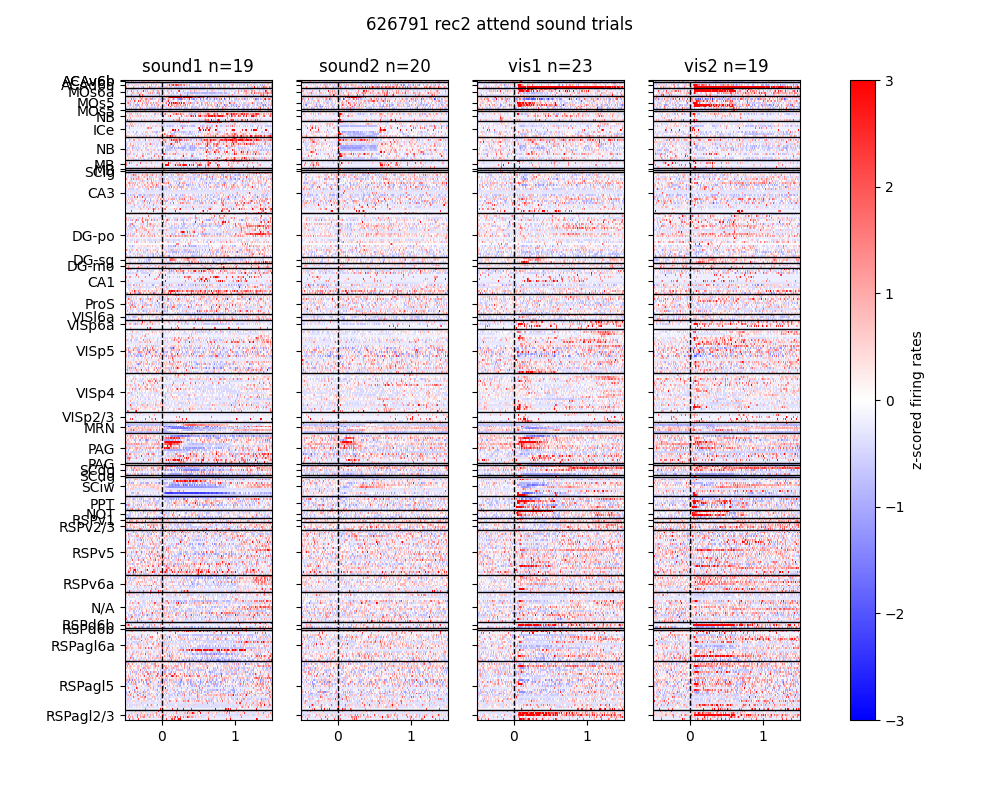

In [120]:
#average across trials where mouse had good sound-performance & plot
attend_sound_trials=session.trials.query('(sound1_interp - vis1_interp)>=0.3')
title=mouseIDs[sel_session]+' rec'+str(exp_nums[sel_session])+' attend sound trials'

unit_frs_by_stim,ntrials_per_stim=average_across_trials(attend_sound_trials)

plot_heatmaps_with_borders(unit_frs_by_stim,trial_duration,time_before_flash,borders,
                               border_midpoints,border_labels,ntrials_per_stim,title)


<IPython.core.display.Javascript object>


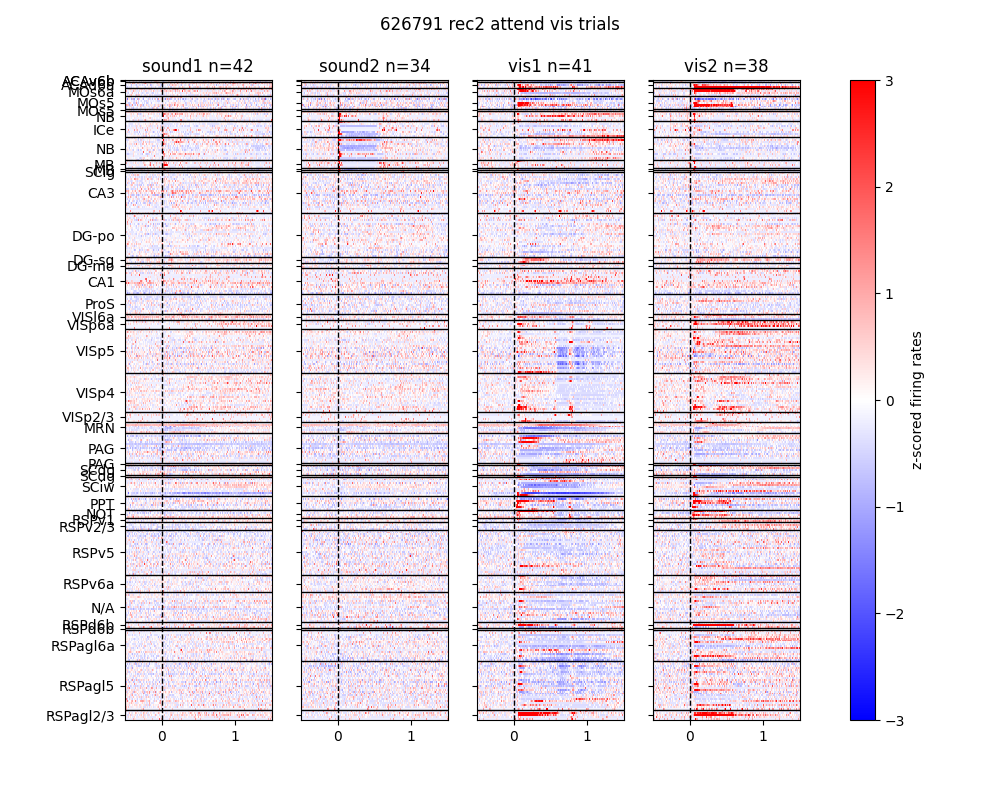

In [121]:
#average across trials where mouse had good vis-performance
attend_vis_trials=session.trials.query('(vis1_interp - sound1_interp)>=0.3')
title=mouseIDs[sel_session]+' rec'+str(exp_nums[sel_session])+' attend vis trials'

unit_frs_by_stim,ntrials_per_stim=average_across_trials(attend_vis_trials)

plot_heatmaps_with_borders(unit_frs_by_stim,trial_duration,time_before_flash,borders,
                               border_midpoints,border_labels,ntrials_per_stim,title)



In [122]:
session.good_units['area'].unique()

array(['ACAv6b', 'ACAv6a', 'ACAd6a', 'MOs6a', 'MOs5', 'N/A', 'NB', 'ICe',
       'MB', 'SCig', 'VISp2/3', 'CA3', 'DG-po', 'DG-sg', 'DG-mo', 'CA1',
       'ProS', 'VISl6a', 'VISp6a', 'VISp5', 'VISp4', 'MRN', 'PAG', 'SCdw',
       'SCdg', 'SCiw', 'PPT', 'NOT', 'RSPv1', 'RSPv2/3', 'RSPv5',
       'RSPv6a', 'RSPd6b', 'RSPagl6b', 'RSPagl6a', 'RSPagl5', 'RSPagl2/3'],
      dtype=object)

In [147]:
# plot PSTHs comparing vis-attend and aud-attend:
attend_vis_trials=session.trials.query('(vis1_interp - sound1_interp)>=0.3')
attend_aud_trials=session.trials.query('(sound1_interp - vis1_interp)>=0.3')

# choose channel range and probe

sel_units_by='area'

#select units to plot by area
area_sel='RSPagl'
#or by channel/probe
channel_range=[120,350]
sel_probe='F'


if sel_units_by=='area':
    sel_units = session.good_units.query('area.str.contains(@area_sel)')
    fig_title=('area '+area_sel+' (n='+str(len(sel_units))+')')
    
elif sel_units_by=='channels':
    sel_units = session.good_units.query('probe == @sel_probe and \
                                           peak_channel >= @channel_range[0] and \
                                           peak_channel < @channel_range[1]')
    fig_title=('probe'+sel_probe+' ch'+str(channel_range[0])+'-'+
               str(channel_range[1])+' (n='+str(len(sel_units))+')')
    
# average PSTH across selected units & each stimulus
stimuli = np.unique(session.trials['trialStimID'])
stim_PSTHs = {}

for stim in stimuli:
    stim_trials_attend_vis = attend_vis_trials.query('trialStimID == @stim').index
    stim_trials_attend_aud = attend_aud_trials.query('trialStimID == @stim').index
    
    stim_PSTHs[stim]={}
    stim_PSTHs[stim]['attend_vis']=[]
    stim_PSTHs[stim]['attend_aud']=[]
    
    stim_PSTHs[stim]['attend_vis'].append(session.trial_da.sel(
                                        unit_id=sel_units.index,
                                        trials=stim_trials_attend_vis).mean(dim=['trials']))
    
    stim_PSTHs[stim]['attend_aud'].append(session.trial_da.sel(
                                        unit_id=sel_units.index,
                                        trials=stim_trials_attend_aud).mean(dim=['trials']))

# smooth each unit's PSTH
gwindow = sg.gaussian(25, std=10)
stim_PSTH_smooth={}
for stim in stimuli:
    stim_PSTH_smooth[stim]={}
    stim_PSTH_smooth[stim]['attend_vis']=np.zeros(stim_PSTHs[stim]['attend_vis'][0].shape)
    stim_PSTH_smooth[stim]['attend_aud']=np.zeros(stim_PSTHs[stim]['attend_aud'][0].shape)
    for iu,uu in enumerate(stim_PSTHs[stim]['attend_vis'][0].unit_id.values):
        stim_PSTH_smooth[stim]['attend_vis'][iu,:]=sg.convolve(stim_PSTHs[stim]['attend_vis'][0].sel(unit_id=uu),
                                                                gwindow,mode='same')/np.sum(gwindow)
        stim_PSTH_smooth[stim]['attend_aud'][iu,:]=sg.convolve(stim_PSTHs[stim]['attend_aud'][0].sel(unit_id=uu),
                                                                gwindow,mode='same')/np.sum(gwindow)

In [76]:
# stim_PSTHs[stim]['attend_vis']

<IPython.core.display.Javascript object>


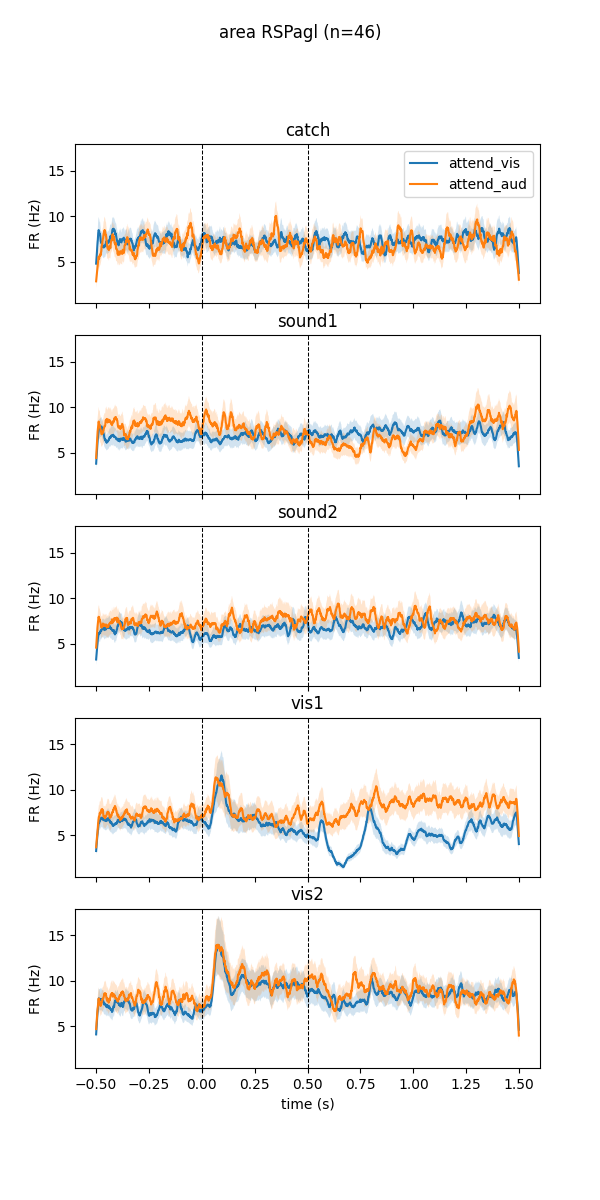

Text(0.5, 0.98, 'area RSPagl (n=46)')

In [148]:
fig,ax=plt.subplots(5,1,figsize=(6,12),sharex=True,sharey=True)

trialconds=['attend_vis','attend_aud']

for ss,stim in enumerate(stimuli):
    ax[ss].set_title(stim)
    
    for tt,trial_type in enumerate(trialconds):
        y=np.nanmean(stim_PSTH_smooth[stim][trial_type],0)
        err=np.nanstd(stim_PSTH_smooth[stim][trial_type],0)/np.sqrt(stim_PSTH_smooth[stim][trial_type].shape[0])
        linex=ax[ss].plot(stim_PSTHs[stim][trial_type][0].time, y)
        ax[ss].fill_between(stim_PSTHs[stim][trial_type][0].time, y-err, y+err,
            alpha=0.2, edgecolor=None, facecolor=linex[0].get_color())
        
        if (ss==0)&(tt==1):
            ax[ss].legend(trialconds)
        
        if tt==1:
            ax[ss].axvline(0,color='k',linestyle='--',linewidth=0.75)
            ax[ss].axvline(0.5,color='k',linestyle='--',linewidth=0.75)
            ax[ss].set_ylabel('FR (Hz)')
            
ax[ss].set_xlabel('time (s)')

fig.suptitle(fig_title)

# ax.set_xlabel('time relative to stimulus onset (s)')
# ax.set_ylabel('firing rate (Hz)')
# ax.set_xlim([-0.4,1.4])

# ax.legend(stimuli)

# stim_lines=[0,0.5]
# for sl in stim_lines:
#     ax.axvline(sl,color='k',linestyle='--',linewidth=0.5)

# fig.tight_layout()

### loop through sessions, find number of units, trials, hit rate, false alarm rate

In [22]:
#define whether trial stimuli were in the rewarded modality

def trialStimInModality(trials):

    trialStimInRewardedModality = np.zeros(len(trials)).astype(bool)
    trialRewardedModality = []
    trialStimModality = []

    for tt,trial in trials.iterrows():

        if trial['trialStimID']!='catch':
            rew_mod=trial['trialstimRewarded'][:-1]
            stim_mod=trial['trialStimID'][:-1]

            trialRewardedModality.append(rew_mod)
            trialStimModality.append(stim_mod)

            trialStimInRewardedModality[tt] = stim_mod==rew_mod
        else:
            trialRewardedModality.append('')
            trialStimModality.append('')

    trials['trialStimModality']=trialStimModality
    trials['trialRewardedModality']=trialRewardedModality   
    trials['trialStimInRewardedModality']=trialStimInRewardedModality
    
    return(trials)

In [30]:
# loop through sessions

session_date=[]
mouse_id=[]

#units
total_n=[]
probeA_n=[]
probeB_n=[]
probeC_n=[]
probeD_n=[]
probeE_n=[]
probeF_n=[]

#trials
n_trials=[]
n_vis_block_trials=[]
n_aud_block_trials=[]
n_catch=[]

vis_go_500=[]
vis_go_750=[]
vis_go_1000=[]

vis_nogo_500=[]
vis_nogo_750=[]
vis_nogo_1000=[]

aud_go_500=[]
aud_go_750=[]
aud_go_1000=[]

aud_nogo_500=[]
aud_nogo_750=[]
aud_nogo_1000=[]

hit_rate=[]
fa_rate=[]
fa_rel_rate=[]
fa_irrel_rate=[]

for ss in main_path:
    session=Session(path=ss) 
    
#     # get mouse number and recording date
#     if "recordings" in ss:
#         sub1 = "recordings"
#     elif "Y:" in ss:
#         sub1 = "Y:"
#     sub2 = "\\processed"
#     idx1 = ss.index(sub1)
#     idx2 = ss.index(sub2)
#     exp_folder=ss[idx1 + len(sub1) + 1: idx2]
#     mouse=exp_folder[-6:]
#     exp=exp_folder[:-7]
    
    session_date.append(session.metadata['ephys_session_num'])
    mouse_id.append(session.metadata['mouseID'])
    
    session.trials = trialStimInModality(session.trials)
    
    #unit info table
    total_n.append(len(session.good_units))
    probeA_n.append(len(session.good_units.query('probe == "A"')))
    probeB_n.append(len(session.good_units.query('probe == "B"')))
    probeC_n.append(len(session.good_units.query('probe == "C"')))
    probeD_n.append(len(session.good_units.query('probe == "D"')))
    probeE_n.append(len(session.good_units.query('probe == "E"')))
    probeF_n.append(len(session.good_units.query('probe == "F"')))
    
    #trial info table
    n_trials.append(len(session.trials))
    n_vis_block_trials.append(len(session.trials.query('trialRewardedModality == "vis"')))
    n_aud_block_trials.append(len(session.trials.query('trialRewardedModality == "sound"')))
    
    vis_go_500.append(len(session.trials.query('trial_stim_dur == 0.5 and trialStimID == "vis1"')))
    vis_go_750.append(len(session.trials.query('trial_stim_dur == 0.75 and trialStimID == "vis1"')))
    vis_go_1000.append(len(session.trials.query('trial_stim_dur == 1.0 and trialStimID == "vis1"')))

    vis_nogo_500.append(len(session.trials.query('trial_stim_dur == 0.5 and trialStimID == "vis2"')))
    vis_nogo_750.append(len(session.trials.query('trial_stim_dur == 0.75 and trialStimID == "vis2"')))
    vis_nogo_1000.append(len(session.trials.query('trial_stim_dur == 1.0 and trialStimID == "vis2"')))

    aud_go_500.append(len(session.trials.query('trial_stim_dur == 0.5 and trialStimID == "sound1"')))
    aud_go_750.append(len(session.trials.query('trial_stim_dur == 0.75 and trialStimID == "sound1"')))
    aud_go_1000.append(len(session.trials.query('trial_stim_dur == 1.0 and trialStimID == "sound1"')))

    aud_nogo_500.append(len(session.trials.query('trial_stim_dur == 0.5 and trialStimID == "sound2"')))
    aud_nogo_750.append(len(session.trials.query('trial_stim_dur == 0.75 and trialStimID == "sound2"')))
    aud_nogo_1000.append(len(session.trials.query('trial_stim_dur == 1.0 and trialStimID == "sound2"')))
    
    n_catch.append(len(session.trials.query('trialStimID == "catch"')))
    
    hit_rate.append(session.trials.query('trialStimID == trialstimRewarded')['trial_response'].mean())
    fa_rate.append(session.trials.query('trialStimID != trialstimRewarded')['trial_response'].mean())
    
    fa_rel_rate.append(session.trials.query('trialStimID != trialstimRewarded and \
                                      trialStimInRewardedModality == True')['trial_response'].mean())
    fa_irrel_rate.append(session.trials.query('trialStimID != trialstimRewarded and \
                                      trialStimInRewardedModality == False')['trial_response'].mean())
    

In [29]:
# if "Y:" in ss:
#     sub1 = "Y:"
# sub2 = "\\processed"
# idx1 = ss.index(sub1)
# idx2 = ss.index(sub2)
# exp_folder=ss[idx1 + len(sub1) + 1: idx2]
# mouse=exp_folder[-6:]
# exp=exp_folder[:-7]

# exp_folder

In [31]:
# make dataframes

unit_summary={
    'session_date':session_date,
    'mouseID':mouse_id,
    'total_n':total_n,
    'probeA_n':probeA_n,
    'probeA_frac_ctx':np.zeros(len(total_n)),
    'probeB_n':probeB_n,
    'probeB_frac_ctx':np.zeros(len(total_n)),
    'probeC_n':probeC_n,
    'probeC_frac_ctx':np.zeros(len(total_n)),
    'probeD_n':probeD_n,
    'probeD_frac_ctx':np.zeros(len(total_n)),
    'probeE_n':probeE_n,
    'probeE_frac_ctx':np.zeros(len(total_n)),
    'probeF_n':probeF_n,
    'probeF_frac_ctx':np.zeros(len(total_n)),
}

unit_summary_df=pd.DataFrame.from_dict(unit_summary)

trial_summary={
    'session_date':session_date,
    'mouseID':mouse_id,
    'n_trials':n_trials,
    'n_vis_block_trials':n_vis_block_trials,
    'n_aud_block_trials':n_aud_block_trials,
    'n_catch':n_catch,

    'vis_go_500':vis_go_500,
    'vis_go_750':vis_go_750,
    'vis_go_1000':vis_go_1000,

    'vis_nogo_500':vis_nogo_500,
    'vis_nogo_750':vis_nogo_750,
    'vis_nogo_1000':vis_nogo_1000,

    'aud_go_500':aud_go_500,
    'aud_go_750':aud_go_750,
    'aud_go_1000':aud_go_1000,

    'aud_nogo_500':aud_nogo_500,
    'aud_nogo_750':aud_nogo_750,
    'aud_nogo_1000':aud_nogo_1000,

    'hit_rate':hit_rate,
    'fa_rate':fa_rate,
    'fa_rel_rate':fa_rel_rate,
    'fa_irrel_rate':fa_irrel_rate,
}

trial_summary_df=pd.DataFrame.from_dict(trial_summary)

In [38]:
unit_summary_df[10:]

session_date mouseID  total_n  probeA_n  probeA_frac_ctx  probeB_n  \
10             1  649944      568         4              0.0       120   
11             2  649944      918       149              0.0       215   

    probeB_frac_ctx  probeC_n  probeC_frac_ctx  probeD_n  probeD_frac_ctx  \
10              0.0       196              0.0         0              0.0   
11              0.0       236              0.0         0              0.0   

    probeE_n  probeE_frac_ctx  probeF_n  probeF_frac_ctx  
10         0              0.0       248              0.0  
11         0              0.0       318              0.0

In [37]:
pd.set_option('display.max_columns', None)
trial_summary_df.loc[10:,:]

session_date mouseID  n_trials  n_vis_block_trials  n_aud_block_trials  \
10             1  649944       673                   0                 606   
11             2  649944       661                   0                 599   

    n_catch  vis_go_500  vis_go_750  vis_go_1000  vis_nogo_500  vis_nogo_750  \
10       67          49          55           46            48            49   
11       62          54          50           45            45            48   

    vis_nogo_1000  aud_go_500  aud_go_750  aud_go_1000  aud_nogo_500  \
10             53          58          47           50            52   
11             57          50          48           55            48   

    aud_nogo_750  aud_nogo_1000  hit_rate   fa_rate  fa_rel_rate  \
10            50             49  0.890323  0.063707     0.152318   
11            52             47  0.986928  0.155512     0.435374   

    fa_irrel_rate  
10       0.027248  
11       0.041551

In [ ]:
# # save dataframes
# save_path=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\templeton pilot summary"

# unit_summary_df.to_csv(os.path.join(save_path,'unit_summary.csv'))
# trial_summary_df.to_csv(os.path.join(save_path,'trial_summary.csv'))

### plot rasters - stim aligned w/ lick time indicated

In [ ]:
#pre - find first lick times in response window

#first - find trials where the mouse licked, find trials where mouse didn't lick

#next - sort first by stimulus and second by lick latency

In [ ]:
# find first licks after stimulus start

first_lick_time=np.zeros(len(session.trials))
first_lick_time[:]=np.nan

for tt in range(0,len(session.trials)):
    if tt<len(session.trials)-1:
        first_lick=np.where((session.lick_times>session.trials['stimStartTime'].iloc[tt])&
                            (session.lick_times<session.trials['stimStartTime'].iloc[tt+1]))[0]
    else:
        first_lick=np.where((session.lick_times>session.trials['stimStartTime'].iloc[tt]))[0]
    
    if len(first_lick)>0:
        first_lick_time[tt]=session.lick_times[first_lick[0]]
        
session.trials['first_lick_time']=first_lick_time
session.trials['first_lick_latency']=session.trials['first_lick_time']-session.trials['stimStartTime']

In [ ]:
response_trials = session.trials.query('trial_response == True')
non_response_trials = session.trials.query('trial_response == False')

In [ ]:
response_trials_sorted = response_trials.sort_values(by=['trialStimID','first_lick_latency'])
non_response_trials_sorted = non_response_trials.sort_values(by=['trialStimID'])

In [ ]:
#Plot rasters - resp vs. non-response, aligned to stimulus

#select unit either by its location in the unit table or its ID    
unit_id=session.good_units.index[310]
# unit_id=10121

fig,ax=plt.subplots(1,2,figsize=(10,7))
ax=ax.flatten()

# stim_types=['vis1','vis2','sound1','sound2','catch']
stim_types=['catch','sound2','sound1','vis2','vis1',]

for xx in range(0,2):
    ax[xx].axvline(0,linewidth=1)
    ax[xx].axvline(0.5,linewidth=1)
    
    trialcount_offset=0
    stim_trial_borders=[0]

    for si,ss in enumerate(stim_types):
        
        if xx==0:
            stim_trials = response_trials_sorted.query('trialStimID == @ss')
        elif xx==1:
            stim_trials = non_response_trials_sorted.query('trialStimID == @ss')
            
        sel_trials = session.trial_da.sel(trials=stim_trials.index.values)

        for it,tt in enumerate(sel_trials.trials.values):
            trial_spikes = sel_trials.sel(unit_id=unit_id,trials=tt)
            trial_spike_times = trial_spikes.time[trial_spikes.values.astype('bool')]
            ax[xx].vlines(trial_spike_times,ymin=it+trialcount_offset,ymax=it+1+trialcount_offset,linewidth=0.75,color='k')

            if stim_trials['trialStimID'].loc[tt] == stim_trials['trialstimRewarded'].loc[tt]:
                plot_color='g'
            else:
                plot_color='r'
            
            if xx==0:
                ax[xx].vlines(stim_trials['first_lick_latency'].loc[tt],ymin=it-.01+trialcount_offset,
                          ymax=it+1.01+trialcount_offset,linewidth=2,color=plot_color)
        ax[xx].axhline(trialcount_offset,color='k',linewidth=0.5)
        trialcount_offset=trialcount_offset+len(stim_trials)
        stim_trial_borders.append(trialcount_offset)

    stim_trial_borders=np.asarray(stim_trial_borders)
    stim_trial_midpoints=stim_trial_borders[:-1]+(stim_trial_borders[1:]-stim_trial_borders[:-1])/2

    for yy in np.asarray([1,3]):
        start_iloc=stim_trial_borders[yy]
        if (yy+1)>(len(stim_trial_borders)-1):
            end_iloc=stim_trial_borders[-1]
        else:
            end_iloc=stim_trial_borders[yy+1]
            
        temp_patch=patches.Rectangle([-0.5,start_iloc],1.5,end_iloc-start_iloc,
                                    color=[0.5,0.5,0.5],alpha=0.10)
        ax[xx].add_patch(temp_patch)

    
    ax[xx].axhline(trialcount_offset,color='k',linewidth=0.5)      
    ax[xx].set_xlim([-0.25,1])
    ax[xx].set_ylim([0,trialcount_offset])
    ax[xx].set_yticks(stim_trial_midpoints)
    ax[xx].set_yticklabels(stim_types)
    ax[xx].set_xlabel('time (s)')
    
    if xx==0:
        ax[xx].set_title('reponse trials')
    elif xx==1:
        ax[xx].set_title('non-reponse trials')
        
        
fig.suptitle('stim-aligned  unit:'+str(unit_id)+'  Probe'+session.good_units['probe'].loc[unit_id]+
             '  ch:'+str(session.good_units['peak_channel'].loc[unit_id])+'  area:'+
             session.good_units['area'].loc[unit_id])

fig.tight_layout()



### plot rasters - lick aligned w/ stim time indicated

In [ ]:
#make a dataframe with 'first_lick_time' relabeled as 'start_time' so the tensor function likes it
first_lick_df=response_trials['first_lick_time']
first_lick_df=pd.DataFrame(first_lick_df)
first_lick_df=first_lick_df.rename(columns={"first_lick_time": "start_time"})

In [ ]:
# loop through sessions and make unit xarrays
time_before_flash = 1.0
trial_duration = 3
bin_size = 0.001


# Make tensor (3-D matrix [units,time,trials])
trial_tensor = make_neuron_time_trials_tensor(session.good_units, session.spike_times, 
                                              first_lick_df, time_before_flash, trial_duration, 
                                              bin_size)

# make xarray
lick_aligned_da = xr.DataArray(trial_tensor, dims=("unit_id", "time", "trials"), 
                           coords={
                               "unit_id": session.good_units.index.values,
                               "time": np.arange(0, trial_duration, bin_size)-time_before_flash,
                               "trials": first_lick_df.index.values
                               })

In [ ]:
#Plot rasters - resp vs. non-response, aligned to stimulus

#select unit either by its location in the unit table or its ID    
unit_id=session.good_units.index[12]
# unit_id=10121

fig,ax=plt.subplots(1,1,figsize=(10,7))

# stim_types=['vis1','vis2','sound1','sound2','catch']
stim_types=['catch','sound2','sound1','vis2','vis1',]


ax.axvline(0,linewidth=1)
# ax.axvline(0.5,linewidth=1)

trialcount_offset=0
stim_trial_borders=[0]

for si,ss in enumerate(stim_types):

    stim_trials = response_trials_sorted.query('trialStimID == @ss')

    sel_trials = lick_aligned_da.sel(trials=stim_trials.index.values)

    for it,tt in enumerate(sel_trials.trials.values):
        trial_spikes = sel_trials.sel(unit_id=unit_id,trials=tt)
        trial_spike_times = trial_spikes.time[trial_spikes.values.astype('bool')]
        ax.vlines(trial_spike_times,ymin=it+trialcount_offset,ymax=it+1+trialcount_offset,linewidth=0.75,color='k')

        if stim_trials['trialStimID'].loc[tt] == stim_trials['trialstimRewarded'].loc[tt]:
            plot_color='g'
        else:
            plot_color='r'


        ax.vlines(-stim_trials['first_lick_latency'].loc[tt],ymin=it-.01+trialcount_offset,
                  ymax=it+1.01+trialcount_offset,linewidth=2,color=plot_color)
        
    ax.axhline(trialcount_offset,color='k',linewidth=0.5)
    trialcount_offset=trialcount_offset+len(stim_trials)
    stim_trial_borders.append(trialcount_offset)

stim_trial_borders=np.asarray(stim_trial_borders)
stim_trial_midpoints=stim_trial_borders[:-1]+(stim_trial_borders[1:]-stim_trial_borders[:-1])/2

for yy in np.asarray([1,3]):
    start_iloc=stim_trial_borders[yy]
    if (yy+1)>(len(stim_trial_borders)-1):
        end_iloc=stim_trial_borders[-1]
    else:
        end_iloc=stim_trial_borders[yy+1]

    temp_patch=patches.Rectangle([-1,start_iloc],2,end_iloc-start_iloc,
                                color=[0.5,0.5,0.5],alpha=0.10)
    ax.add_patch(temp_patch)


ax.axhline(trialcount_offset,color='k',linewidth=0.5)      
ax.set_xlim([-1,1])
ax.set_ylim([0,trialcount_offset])
ax.set_yticks(stim_trial_midpoints)
ax.set_yticklabels(stim_types)
ax.set_xlabel('time (s)')

# if xx==0:
#     ax.set_title('reponse trials')
# elif xx==1:
#     ax.set_title('non-reponse trials')
        
        
fig.suptitle('lick-aligned  unit:'+str(unit_id)+'  Probe'+session.good_units['probe'].loc[unit_id]+
             '  ch:'+str(session.good_units['peak_channel'].loc[unit_id])+'  area:'+
             session.good_units['area'].loc[unit_id])

fig.tight_layout()

